In [12]:
import os
import zipfile
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


sns.set_theme(palette=sns.color_palette('bright'), style='ticks')
sns.set_style({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.facecolor': '#EAEAF2',
})
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['scatter.edgecolors'] = 'face'
plt.rcParams['figure.autolayout'] = False

# Task 0

## Extract Data

In [13]:
### Basic Settings

# create directories
DATA_PATH = './data'
FIG_PATH = './figures'
for path in [DATA_PATH, FIG_PATH]:
    if not os.path.isdir(path):
        os.mkdir(path)

# extract data from compressed files
author_nodes = 'AMiner-Author'
author_edges = 'AMiner-Coauthor'
for file in [author_nodes, author_edges]:
    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall(DATA_PATH)

## Get Nodes and Links for Authors with Interest in Social Network

In [14]:
### Data Processing

# Nodes
nodes = set()
with open(os.path.join(DATA_PATH, author_nodes+'.txt'), 'r') as nodes_file:
    for line in nodes_file:
        if '#index' in line:
            index = int(line.split(maxsplit=1)[-1])
        if '#t' in line:
            if 'social network' in line.split(maxsplit=1)[-1].lower():
                nodes.add(index)

# Edges
edges = set()
with open(os.path.join(DATA_PATH, author_edges+'.txt'), 'r') as edges_file:
    for line in edges_file:
        n1, n2, _ = line[1:].split()
        n1, n2 = int(n1), int(n2)
        if n1 in nodes and n2 in nodes:
            if n1 < n2:
                edges.add((n1, n2))
            else:
                edges.add((n2, n1))

## Get the Giant Component

In [15]:
### Get the giant component
original_g = nx.from_edgelist(edges)
gcc = sorted(nx.connected_components(original_g), key=len, reverse=True)[0]
g_author = original_g.subgraph(gcc)

g_n_nodes = g_author.number_of_nodes()
g_n_edges = g_author.number_of_edges()

print('='*10+' Giant Component '+'='*10)
print(f'Number of nodes: {g_n_nodes}')
print(f'Number of edges: {g_n_edges}')

========== Giant Component ==========
Number of nodes: 2068
Number of edges: 5163


## Generate a Random Network

In [16]:
g_rand = nx.gnm_random_graph(g_n_nodes, g_n_edges, seed=794)
print('='*10+' Random Network '+'='*10)
print(f'Number of nodes: {g_rand.number_of_nodes()}')
print(f'Number of edges: {g_rand.number_of_edges()}')
print(f'Is connected?  : {nx.is_connected(g_rand)}')

========== Random Network ==========
Number of nodes: 2068
Number of edges: 5163
Is connected?  : True


## Generate a BA Network

In [17]:
def gen_ba_graph(n_nodes, n_edges):
    # start with a small random network
    init_nodes, init_edges = 20, 40
    g_ba = nx.gnm_random_graph(init_nodes, init_edges, seed=794)
    # number of new edges added for each new node
    n_new_edges = (n_edges - init_edges) // (n_nodes - init_nodes)
    # add one new node each time until the last node
    for n_node in range(init_nodes+1, n_nodes):
        g_ba = nx.barabasi_albert_graph(n_node, n_new_edges,
                                        initial_graph=g_ba)
        n_new_edges = (n_edges - g_ba.number_of_edges()) // (n_nodes - n_node)

    # add all remaining edges to the last node
    remained_edges = n_edges - g_ba.number_of_edges()
    g_ba = nx.barabasi_albert_graph(n_nodes, remained_edges,
                                    initial_graph=g_ba)
    return g_ba

g_ba = gen_ba_graph(g_n_nodes, g_n_edges)
print('='*10+' BA Network '+'='*10)
print(f'Number of nodes: {g_ba.number_of_nodes()}')
print(f'Number of edges: {g_ba.number_of_edges()}')
print(f'Is connected?  : {nx.is_connected(g_ba)}')

========== BA Network ==========
Number of nodes: 2068
Number of edges: 5163
Is connected?  : True


# Task 1

## Degree Statistics

In [18]:
graphs = [
    (g_author, 'Author Network'),
    (g_rand, 'Random Network'),
    (g_ba, 'BA Network'),
]

data = []
for graph, name in graphs:
    degrees = [d for _, d in graph.degree]
    data.append({
        'Network': name,
        'Mean Degree': np.mean(degrees),
        'Max Degree': np.max(degrees),
    })

pd.DataFrame(data).style.hide()

Network,Mean Degree,Max Degree
Author Network,4.993230,51
Random Network,4.993230,15
BA Network,4.993230,119


## Degree Distributions

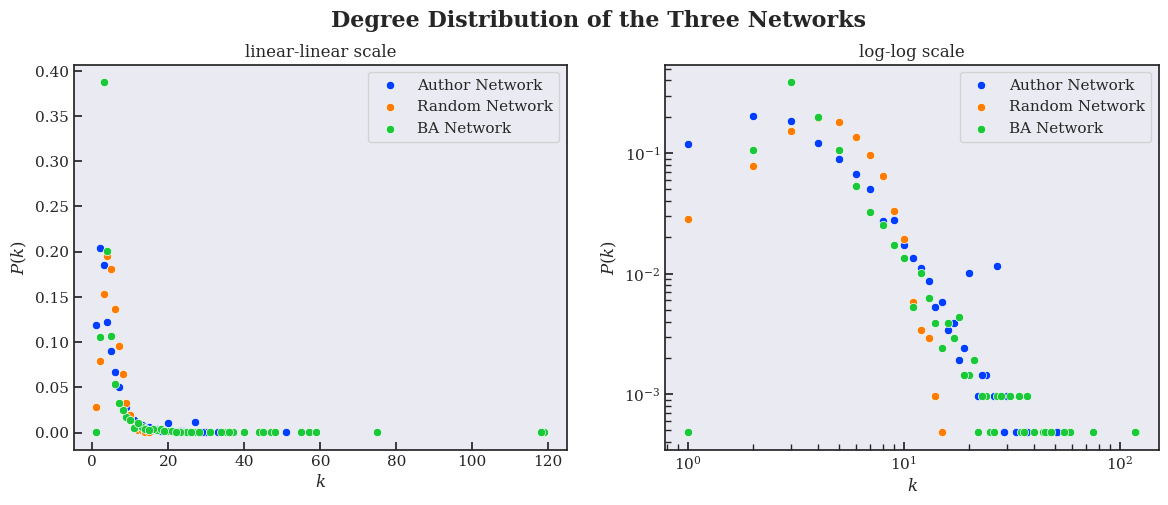

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

data = []
for graph, name in graphs:
    degrees = np.array([d for _, d in graph.degree])
    x, y = zip(*Counter(degrees).items())
    x = np.array(x)
    y = np.array(y) / graph.number_of_nodes()
    sns.scatterplot(x=x, y=y, label=name, ax=ax[0])
    sns.scatterplot(x=x, y=y, label=name, ax=ax[1])

fig.suptitle('Degree Distribution of the Three Networks',
             fontweight='bold', fontsize=16, y=0.99)

ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$P(k)$')
ax[0].set_title('linear-linear scale')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$P(k)$')
ax[1].set_title('log-log scale')

fig.savefig(os.path.join(FIG_PATH, 'task_1_degree_distribution.pdf'), bbox_inches='tight')

## Power-law Exponent Estimation of the Author Network

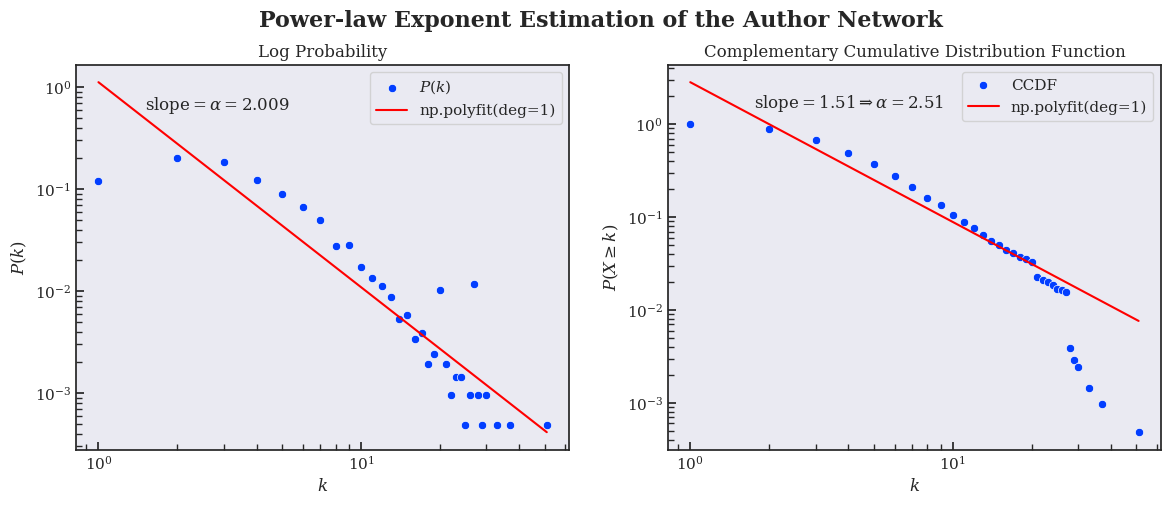

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle('Power-law Exponent Estimation of the Author Network',
             fontweight='bold', fontsize=16, y=0.99)

graph = g_author
degrees = np.array([d for _, d in graph.degree])
degrees_probs = sorted(Counter(degrees).items(), key=lambda x: x[0])

x, y = zip(*sorted(Counter(degrees).items()))
x = np.array(x)
y = np.array(y) / graph.number_of_nodes()
sns.scatterplot(x=x, y=y, label='$P(k)$', ax=ax[0])

log_x = np.log10(x)
log_y = np.log10(y)
w = np.polyfit(log_x, log_y, deg=1)
x_dump = np.linspace(np.min(x), np.max(x), 100)
y_dump = (x_dump ** w[0]) * (10 ** w[1])
sns.lineplot(x=x_dump, y=y_dump, ax=ax[0], color='red', label='np.polyfit(deg=1)')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$P(k)$')
ax[0].set_title('Log Probability')
ax[0].text(1.5, 0.6, f'slope$=\\alpha = {-w[0]:.4}$')


ccdf = [1]
for prob in y[:-1]:
    ccdf.append(ccdf[-1] - prob)
sns.scatterplot(x=x, y=ccdf, label='CCDF', ax=ax[1])
# print(np.log10(ccdf))

log_ccdf = np.log10(ccdf)[:-6]
log_x = log_x[:-6]
w_ccdf = np.polyfit(log_x, log_ccdf, deg=1)
ccdf_dump = (x_dump ** w_ccdf[0]) * (10 ** w_ccdf[1])
sns.lineplot(x=x_dump, y=ccdf_dump, ax=ax[1], color='red', label='np.polyfit(deg=1)')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$P(X \geq k)$')
ax[1].set_title('Complementary Cumulative Distribution Function')
ax[1].text(1.75, 1.5, f"slope$= {-w_ccdf[0]:.3} \Rightarrow \\alpha = {1-w_ccdf[0]:.3}$")

fig.savefig(os.path.join(FIG_PATH, 'task_1_exponent_estimation.pdf'), bbox_inches='tight')

# Task 2

## Nearest Neighbours Average Degree

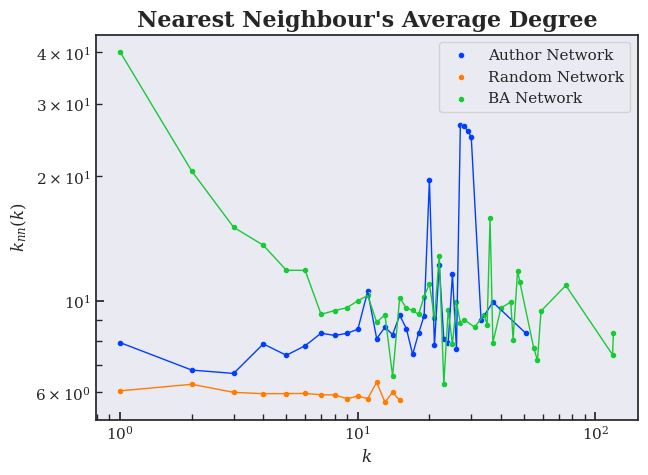

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for n, (graph, name) in enumerate(graphs):
    n = 0
    x, y = zip(*sorted(nx.average_degree_connectivity(graph).items()))
    sns.scatterplot(x=x, y=y, label=name, ax=ax, s=20)
    sns.lineplot(x=x, y=y, ax=ax, linewidth=1)

    ax.set_xlabel('$k$')
    ax.set_ylabel('$k_{nn}(k)$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Nearest Neighbour's Average Degree", fontsize=16, fontweight='bold')


fig.savefig(os.path.join(FIG_PATH, 'task_2_knn.pdf'), bbox_inches='tight')

## Assortative Coefficient

In [22]:
data = [
    {
        'Network': name,
        'Assortative Coefficien': nx.degree_assortativity_coefficient(graph),
    }
    for graph, name in graphs
]
pd.DataFrame(data).style.hide()

Network,Assortative Coefficien
Author Network,0.472605
Random Network,-0.022553
BA Network,-0.070762


# Task 3

## Diameter and Average Shortest Path Length

In [23]:
data = [
    {
        'Network': name,
        'Diameter': nx.diameter(graph),
        'Average Shortest Path Length': nx.average_shortest_path_length(graph),
    }
    for graph, name in graphs
]
pd.DataFrame(data).style.hide()

Network,Diameter,Average Shortest Path Length
Author Network,19,7.301106
Random Network,10,4.938204
BA Network,7,4.108881


## Average Node Betweenness

In [24]:
bs = [nx.betweenness_centrality(graph, normalized=True) for graph, _ in graphs ]

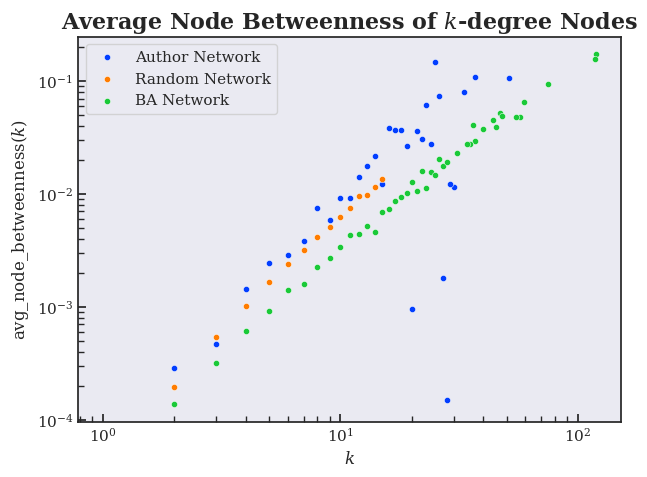

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for (graph, name), betweenness in zip(graphs, bs):

    degree_group = {}
    for n, k in graph.degree:
        degree_group.setdefault(k, []).append(n)

    x, y = [], []
    for k, nodes in degree_group.items():
        x.append(k)
        y.append(np.sum([betweenness[n] for n in nodes]) / len(nodes))

    sns.scatterplot(x=x, y=y, ax=ax, label=name, s=20)
    # sns.lineplot(x=x, y=y, ax=ax)

ax.set_xlabel('$k$')
ax.set_ylabel('avg_node_betweenness$(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Average Node Betweenness of $k$-degree Nodes", fontsize=16, fontweight='bold')
ax.legend()

fig.savefig(os.path.join(FIG_PATH, 'task_3_betweenness.pdf'), bbox_inches='tight')

# Task 4

## Rich-club Coefficient

In [26]:
def rich_club_coefficient_rank(graph):
    ranks = [n for n, _ in sorted(graph.degree, key=lambda x: -x[1])]
    max_rank = len(ranks)
    coefficients = {}
    for rank in range(2, max_rank+1):
        rank_subgraph = graph.subgraph(ranks[:rank])
        coefficients[rank] = rank_subgraph.number_of_edges()*2/rank/(rank-1)
    return coefficients

rank_rcs = [rich_club_coefficient_rank(graph) for graph, _ in graphs]
degree_rcs = [nx.rich_club_coefficient(graph, False) for graph, _ in graphs]

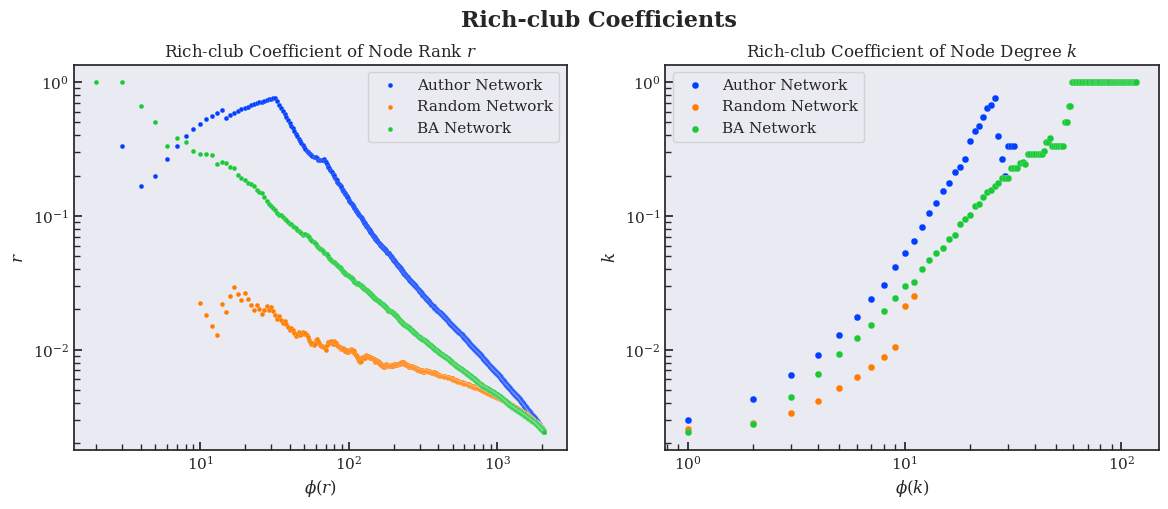

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for (graph, name), rank_rc in zip(graphs, rank_rcs):
    x, y = zip(*rank_rc.items())
    sns.scatterplot(x=x, y=y, label=name, ax=ax[0], marker='.', linewidth=0.1, s=48)

fig.suptitle('Rich-club Coefficients',
             fontweight='bold', fontsize=16, y=0.99)

ax[0].set_xlabel('$\phi(r)$')
ax[0].set_ylabel('$r$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Rich-club Coefficient of Node Rank $r$')

for (graph, name), degree_rc in zip(graphs, degree_rcs):
    x, y = zip(*degree_rc.items())
    sns.scatterplot(x=x, y=y, label=name, ax=ax[1], marker='.', linewidth=0.1, s=96)

ax[1].set_xlabel('$\phi(k)$')
ax[1].set_ylabel('$k$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Rich-club Coefficient of Node Degree $k$')

fig.savefig(os.path.join(FIG_PATH, 'task_4_rich_club_coefficient.png'), bbox_inches='tight')

# Task 5

## Community Plot Untilities

In [28]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

## Compute and Draw Communities

========== Author Network ==========
47
Community 1 size 126
Community 2 size 115
Community 3 size 115
Overall modularity of the partition: 0.9022093766080699

========== Random Network ==========
23
Community 1 size 148
Community 2 size 133
Community 3 size 130
Overall modularity of the partition: 0.4484370625491975

========== BA Network ==========
22
Community 1 size 224
Community 2 size 203
Community 3 size 181
Overall modularity of the partition: 0.4477992460320006



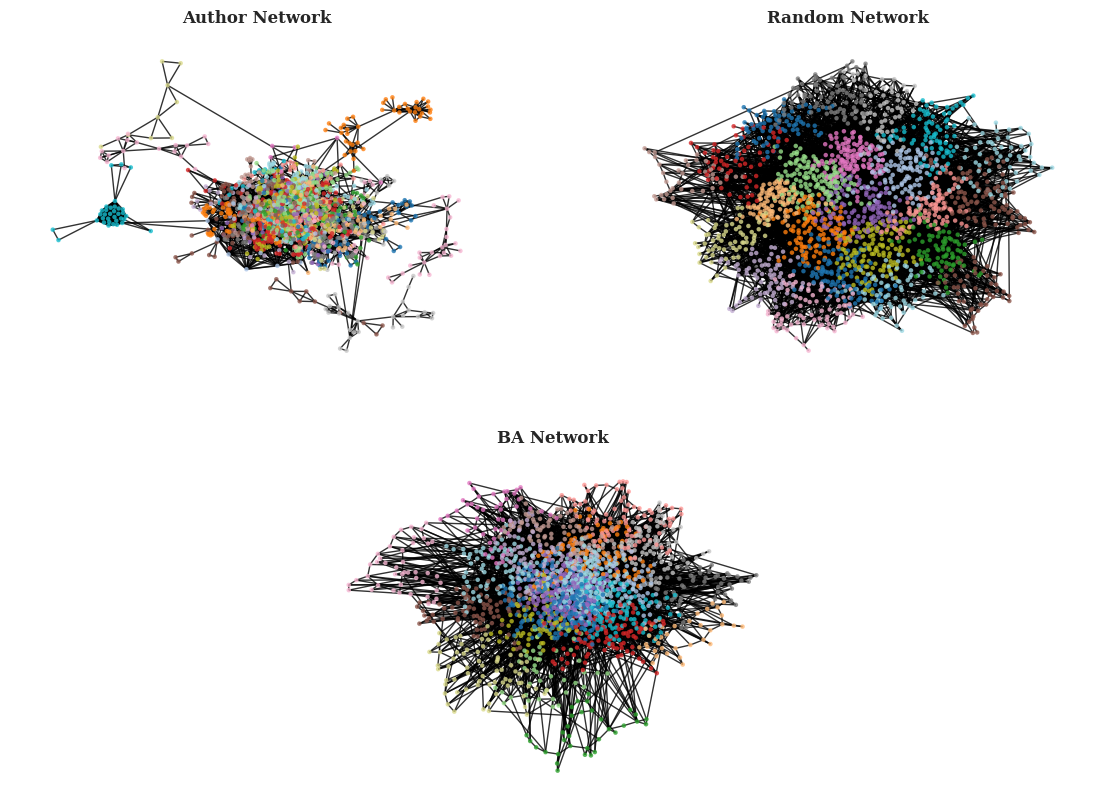

In [29]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
ax = (ax1, ax2, ax3)


for n, (graph, name) in enumerate(graphs):

    # Find the best partition
    communities = nx.community.louvain_communities(graph)

    # Calculate the modularity
    modularity = nx.community.modularity(graph, communities)

    # Sort communities by the number of nodes in each community (largest first)
    sorted_communities = sorted(communities, key=lambda x: len(x), reverse=True)
    top_3_communities = sorted_communities[:3]

    print('='*10+f' {name} '+'='*10)
    print(len(communities))
    for i, community in enumerate(top_3_communities, start=1):
        print(f'Community {i} size {len(community)}')

    # Print overall modularity of the partition
    print(f'Overall modularity of the partition: {modularity}')
    print()

    partition_map = {node: n for n, comm in enumerate(communities)
                    for node in comm}
    pos = community_layout(graph, partition_map)
    nx.draw(graph, pos, ax=ax[n], node_size=10, linewidths=0.05, cmap='tab20', alpha=0.8,
            node_color=[partition_map[n] for n in graph.nodes()])

    ax[n].set_title(name, fontweight='bold')

fig.savefig(os.path.join(FIG_PATH, 'task_5_community.png'), bbox_inches='tight')

# Task 6

In [30]:
swaps = 500000

data = []
graphs_mod = []
for graph, name in graphs:
    data.append({
        'Network': name,
        'Average Clustering Coefficient': nx.average_clustering(graph),
        'Assortative Coefficien': nx.degree_assortativity_coefficient(graph),
        'Size': graph.number_of_nodes(),
        'Average Shortest Path Length': nx.average_shortest_path_length(graph),

    })

    graph_copy = graph.copy()
    graph_copy = nx.double_edge_swap(graph_copy, swaps, swaps*10)

    graphs_mod.append(graph_copy)

    gcc = sorted(nx.connected_components(graph_copy), key=len, reverse=True)[0]
    giant = graph_copy.subgraph(gcc)


    data.append({
        'Network': name+' mod',
        'Average Clustering Coefficient': nx.average_clustering(graph_copy),
        'Assortative Coefficien': nx.degree_assortativity_coefficient(graph_copy),
        'Size': giant.number_of_nodes(),
        'Average Shortest Path Length': nx.average_shortest_path_length(giant),
    })

pd.DataFrame(data).style.hide()

Network,Average Clustering Coefficient,Assortative Coefficien,Size,Average Shortest Path Length
Author Network,0.619669,0.472605,2068,7.301106
Author Network mod,0.005092,-0.034097,2068,4.396470
Random Network,0.002975,-0.022553,2068,4.938204
Random Network mod,0.002962,-0.005941,2068,4.943887
BA Network,0.012659,-0.070762,2068,4.108881
BA Network mod,0.010841,-0.038226,2068,4.200007


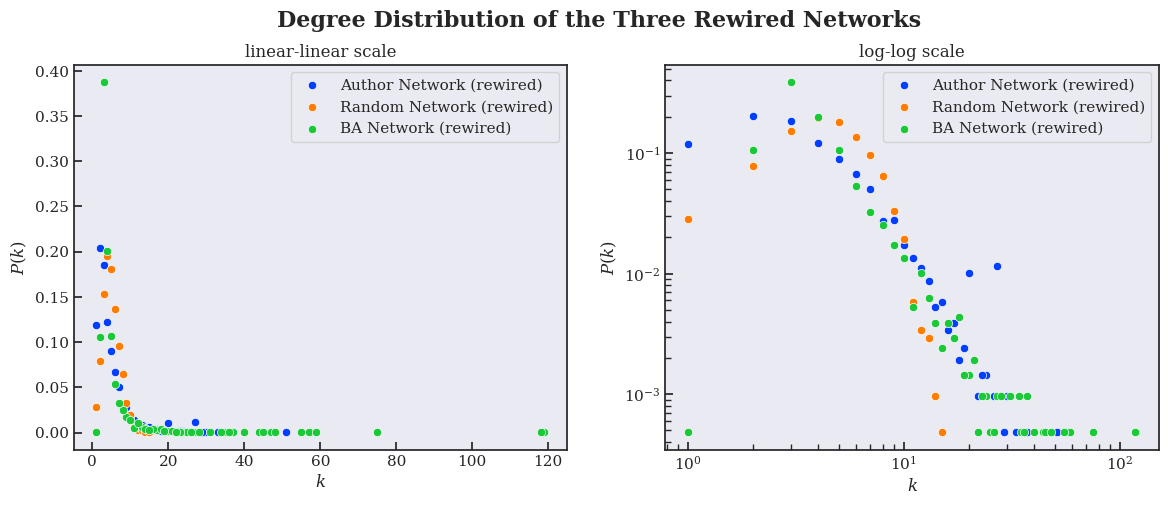

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

data = []
for (_, name), graph_mod in zip(graphs, graphs_mod):
    x = []
    y = []
    degrees = np.array([d for _, d in graph_mod.degree])
    for k, v in Counter(degrees).items():
        x.append(k)
        y.append(v)
    x = np.array(x)
    y = np.array(y) / graph_mod.number_of_nodes()
    sns.scatterplot(x=x, y=y, label=name+' (rewired)', ax=ax[0])
    sns.scatterplot(x=x, y=y, label=name+' (rewired)', ax=ax[1])

fig.suptitle('Degree Distribution of the Three Rewired Networks',
             fontweight='bold', fontsize=16, y=0.99)

ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$P(k)$')
ax[0].set_title('linear-linear scale')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$P(k)$')
ax[1].set_title('log-log scale')

fig.savefig(os.path.join(FIG_PATH, 'task_6_degree_distribution.pdf'), bbox_inches='tight')